# Capstone Project – The Battle of Neighborhoods | Finding a Better Place in Scarborough, Toronto

### 1. Installing and Importing Python Libraries and Dependencies

In [3]:
!pip install geocoder
!pip install folium

Importing Libraries

In [4]:
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

All Required Libraries Imported!


### 2.  Data Extraction and Cleaning

Using BeautifulSoup Scraping List of Postal Codes of Given Wikipedia Page. 
Link: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [5]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
extracting_data = requests.get(url).text
wiki_data = BeautifulSoup(extracting_data, 'lxml')

Converting content of PostalCode HTML table as dataframe

In [6]:
column_names = ['Postalcode','Borough','Neighborhood']
toronto = pd.DataFrame(columns = column_names)

content = wiki_data.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text
            i = i + 1
        elif i == 1:
            borough = td.text
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
    toronto = toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)

In [7]:
# clean dataframe 
toronto = toronto[toronto.Borough!='Not assigned']
toronto = toronto[toronto.Borough!= 0]
toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto.shape[0]):
    if toronto.iloc[i][2] == 'Not assigned':
        toronto.iloc[i][2] = toronto.iloc[i][1]
        i = i+1

In [8]:
df = toronto.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [9]:
df.describe()

,Postalcode,Borough,Neighborhood
count,103,103,103
unique,103,10,103
top,M3K,North York,"CN Tower, Bathurst Quay, Island airport, Harbo..."
freq,1,24,1


In [10]:
df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]

In [11]:
df.head()

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [12]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [13]:
df_2.describe()

,Postalcode,Borough,Neighborhood
count,103,103,103
unique,103,10,103
top,M3K,North York,"CN Tower, Bathurst Quay, Island airport, Harbo..."
freq,1,24,1


In [14]:
print(df_2.shape)
df_2.head()

(103, 3)


,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [15]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M4G')

[43.70949500000006, -79.36398897099997]

In [21]:
# Retrieving Postal Code Co-ordinates
postal_codes = df_2['Postalcode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [22]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']

In [23]:
df_2[df_2.Postalcode == 'M5G']

,Postalcode,Borough,Neighborhood,Latitude,Longitude
57,M5G,Downtown Toronto,Central Bay Street,43.656091,-79.38493


In [24]:
df_2.head(10)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.811525,-79.195517
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.785665,-79.158725
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.765815,-79.175193
3,M1G,Scarborough,Woburn,43.768369,-79.217590
4,M1H,Scarborough,Cedarbrae,43.769688,-79.239440
5,M1J,Scarborough,Scarborough Village,43.743125,-79.231750
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.726276,-79.263625
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.713054,-79.285055
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.724235,-79.227925
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.696770,-79.259967


In [25]:
address = 'Scarborough,Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Seattle,Washington are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Seattle,Washington are 43.773077, -79.257774.


### 3. Map of Scarborough

In [26]:
map_Scarborough = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Scarborough)  
    
map_Scarborough

In [27]:
address = 'Scarborough,Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Neighborhood_1 are 43.773077, -79.257774.


In [28]:
# @hiddel_cell
CLIENT_ID = 'DPBYY4JUY3DU20ALPSUV4ONY2K1GOJJKJ1NIHBB32XEMOVYY' # my Foursquare ID
CLIENT_SECRET = '1MV443TYEP4HUO0WDUW5NQ5W10L2Y4G05NWG11WIR3NUGC5B' # my Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: DPBYY4JUY3DU20ALPSUV4ONY2K1GOJJKJ1NIHBB32XEMOVYY
CLIENT_SECRET: 1MV443TYEP4HUO0WDUW5NQ5W10L2Y4G05NWG11WIR3NUGC5B


In [29]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [30]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.categories',
       'venue.events.count', 'venue.events.summary', 'venue.id',
       'venue.location.address', 'venue.location.cc', 'venue.location.city',
       'venue.location.country', 'venue.location.crossStreet',
       'venue.location.distance', 'venue.location.formattedAddress',
       'venue.location.labeledLatLngs', 'venue.location.lat',
       'venue.location.lng', 'venue.location.neighborhood',
       'venue.location.postalCode', 'venue.location.state', 'venue.name',
       'venue.photos.count', 'venue.photos.groups', 'venue.venuePage.id'],
      dtype='object')

In [31]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### 4. Nearby Venues/Locations

In [32]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Disney Store,"[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",43.775537,-79.256833
1,SEPHORA,"[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",43.775017,-79.258109
2,American Eagle Outfitters,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776012,-79.258334
3,St. Andrews Fish & Chips,"[{'id': '4edd64a0c7ddd24ca188df1a', 'name': 'F...",43.771865,-79.252645
4,Canyon Creek Chophouse,"[{'id': '4bf58dd8d48988d1cc941735', 'name': 'S...",43.776959,-79.261694


### 5. Categories of Nearby Venues/Locations

In [33]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Disney Store,Toy / Game Store,43.775537,-79.256833
1,SEPHORA,Cosmetics Shop,43.775017,-79.258109
2,American Eagle Outfitters,Clothing Store,43.776012,-79.258334
3,St. Andrews Fish & Chips,Fish & Chips Shop,43.771865,-79.252645
4,Canyon Creek Chophouse,Steakhouse,43.776959,-79.261694


In [34]:
# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Clothing Store         7
Coffee Shop            5
Restaurant             3
Cosmetics Shop         2
Pharmacy               2
Tea Room               2
Gas Station            2
Sandwich Place         2
Shopping Mall          1
Sporting Goods Shop    1
Name: categories, dtype: int64

In [35]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [36]:
# Nearby Venues
Scarborough_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

In [37]:
print('There are {} Uniques Categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head()

There are 308 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Agincourt,28,28,28,28,28,28
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",5,5,5,5,5,5
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",13,13,13,13,13,13
"Alderwood, Long Branch",7,7,7,7,7,7


### One Hot Encoding of Features

In [38]:
# one hot encoding
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(5)

,Zoo Exhibit,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stationery Store,Steakhouse,Storage Facility,Supermarket,Sushi Re

In [39]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Adelaide, King, Richmond ----
                venue  freq
0          Restaurant  0.07
1         Coffee Shop  0.07
2                Café  0.07
3               Hotel  0.05
4  Seafood Restaurant  0.03


---- Agincourt ----
                      venue  freq
0             Shopping Mall  0.11
1        Chinese Restaurant  0.07
2  Mediterranean Restaurant  0.04
3       Shanghai Restaurant  0.04
4               Supermarket  0.04


---- Agincourt North, L'Amoreaux East, Milliken, Steeles East ----
              venue  freq
0        Playground   0.2
1          Pharmacy   0.2
2               Gym   0.2
3  Sushi Restaurant   0.2
4    Sandwich Place   0.2


---- Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown ----
                  venue  freq
0         Grocery Store  0.15
1        Hardware Store  0.08
2   Fried Chicken Joint  0.08
3  Caribbean Restaurant  0.08
4              Gym Pool  0.08


---- Alderwood, Long Branch ----
         

                venue  freq
0  Athletics & Sports  0.17
1            Bus Line  0.17
2         Coffee Shop  0.17
3  Italian Restaurant  0.17
4      Farmers Market  0.17


---- Emery, Humberlea ----
                       venue  freq
0                Coffee Shop  0.29
1                  Nightclub  0.14
2                       Park  0.14
3  Latin American Restaurant  0.14
4             Discount Store  0.14


---- Fairview, Henry Farm, Oriole ----
                  venue  freq
0        Clothing Store  0.12
1  Fast Food Restaurant  0.07
2           Coffee Shop  0.07
3   Japanese Restaurant  0.03
4     Convenience Store  0.03


---- First Canadian Place, Underground city ----
                 venue  freq
0          Coffee Shop  0.11
1                 Café  0.07
2                Hotel  0.07
3           Restaurant  0.06
4  Japanese Restaurant  0.03


---- Flemingdon Park, Don Mills South ----
              venue  freq
0       Coffee Shop  0.08
1        Beer Store  0.08
2               Gym  0.0

                       venue  freq
0                Coffee Shop  0.11
1             Clothing Store  0.05
2  Middle Eastern Restaurant  0.04
3                 Restaurant  0.04
4          Electronics Store  0.02


---- Scarborough Village ----
                  venue  freq
0        Sandwich Place  0.22
1        Ice Cream Shop  0.22
2         Big Box Store  0.11
3  Fast Food Restaurant  0.11
4            Restaurant  0.11


---- Silver Hills, York Mills ----
                 venue  freq
0                 Park   1.0
1          Zoo Exhibit   0.0
2  Monument / Landmark   0.0
3          Music Venue   0.0
4          Music Store   0.0


---- St. James Town ----
                venue  freq
0         Coffee Shop  0.09
1                Café  0.07
2          Restaurant  0.05
3  Italian Restaurant  0.04
4              Bakery  0.04


---- Stn A PO Boxes 25 The Esplanade ----
         venue  freq
0  Coffee Shop  0.07
1         Café  0.05
2   Restaurant  0.05
3          Bar  0.04
4        Hotel  0.04




In [40]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Most Common venues near neighborhood

In [41]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Café,Restaurant,Coffee Shop,Hotel,Gastropub,Breakfast Spot,Seafood Restaurant,Steakhouse,Asian Restaurant,Japanese Restaurant
1,Agincourt,Shopping Mall,Chinese Restaurant,Pizza Place,Supermarket,Sushi Restaurant,Discount Store,Motorcycle Shop,Coffee Shop,Mediterranean Restaurant,Bank
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Playground,Sushi Restaurant,Sandwich Place,Gym,Pharmacy,Farmers Market,Fast Food Restaurant,Doctor's Office,Dog Run,Doner Restaurant
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Pizza Place,Liquor Store,Fast Food Restaurant,Sandwich Place,Fried Chicken Joint,Caribbean Restaurant,Park,Beer Store,Gym Pool
4,"Alderwood, Long Branch",Gas Station,Coffee Shop,Pizza Place,Pharmacy,Sandwich Place,Pub,Gym,Distribution Center,Dive Bar,Doctor's Office


### K-Means Clustering Approach

In [42]:
# Using K-Means to cluster neighborhood into 3 clusters
Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(Scarborough_grouped_clustering)
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [43]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Scarborough_merged =df_2.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Scarborough_merged.head()# check the last columns!

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.811525,-79.195517,0,Zoo Exhibit,Climbing Gym,Fast Food Restaurant,Construction & Landscaping,African Restaurant,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.785665,-79.158725,0,Bar,History Museum,Fish & Chips Shop,Ethiopian Restaurant,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.765815,-79.175193,1,Park,Gym / Fitness Center,Athletics & Sports,Yoga Studio,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
3,M1G,Scarborough,Woburn,43.768369,-79.217590,0,Coffee Shop,Fast Food Restaurant,Business Service,Park,Yoga Studio,Ethiopian Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
4,M1H,Scarborough,Cedarbrae,43.769688,-79.239440,0,Lounge,Athletics & Sports,Caribbean Restaurant,Gas Station,Bank,Thai Restaurant,Bakery,Indian Restaurant,Flower Shop,Hakka Restaurant


### Map of Clusters

In [44]:
kclusters = 10

In [45]:
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(Scarborough_merged['Latitude'], 
                                   Scarborough_merged['Longitude'], 
                                   Scarborough_merged['Neighborhood'], 
                                   Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [46]:
df1=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df2=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df3=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 2,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

In [47]:
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0
                                                              
                                                              
                                                              ]})

In [48]:
Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

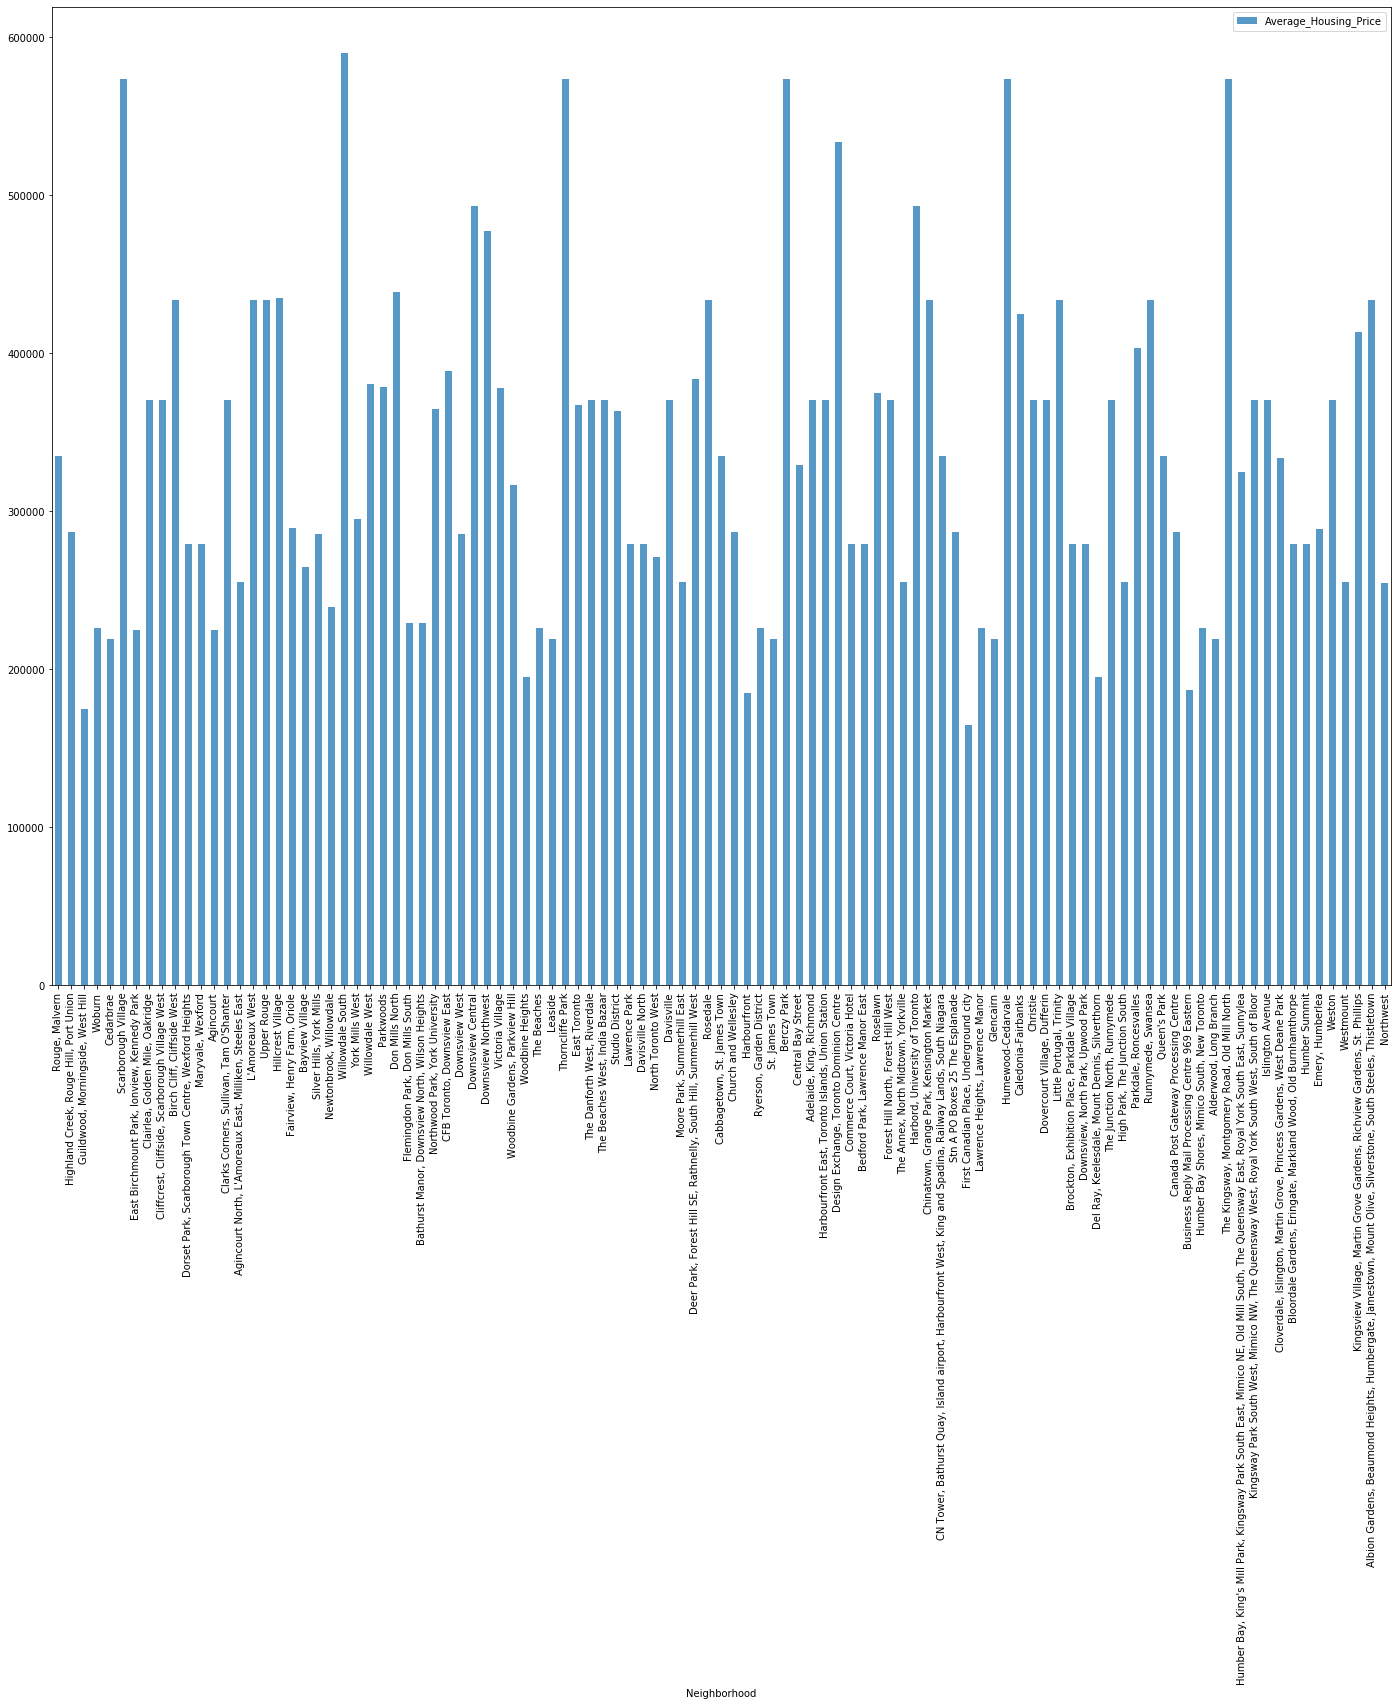

In [49]:
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

### School Rating by Clusters

In [50]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [51]:
new_Scarborough=Scarborough_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
Scarborough_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})

In [52]:
Scarborough_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

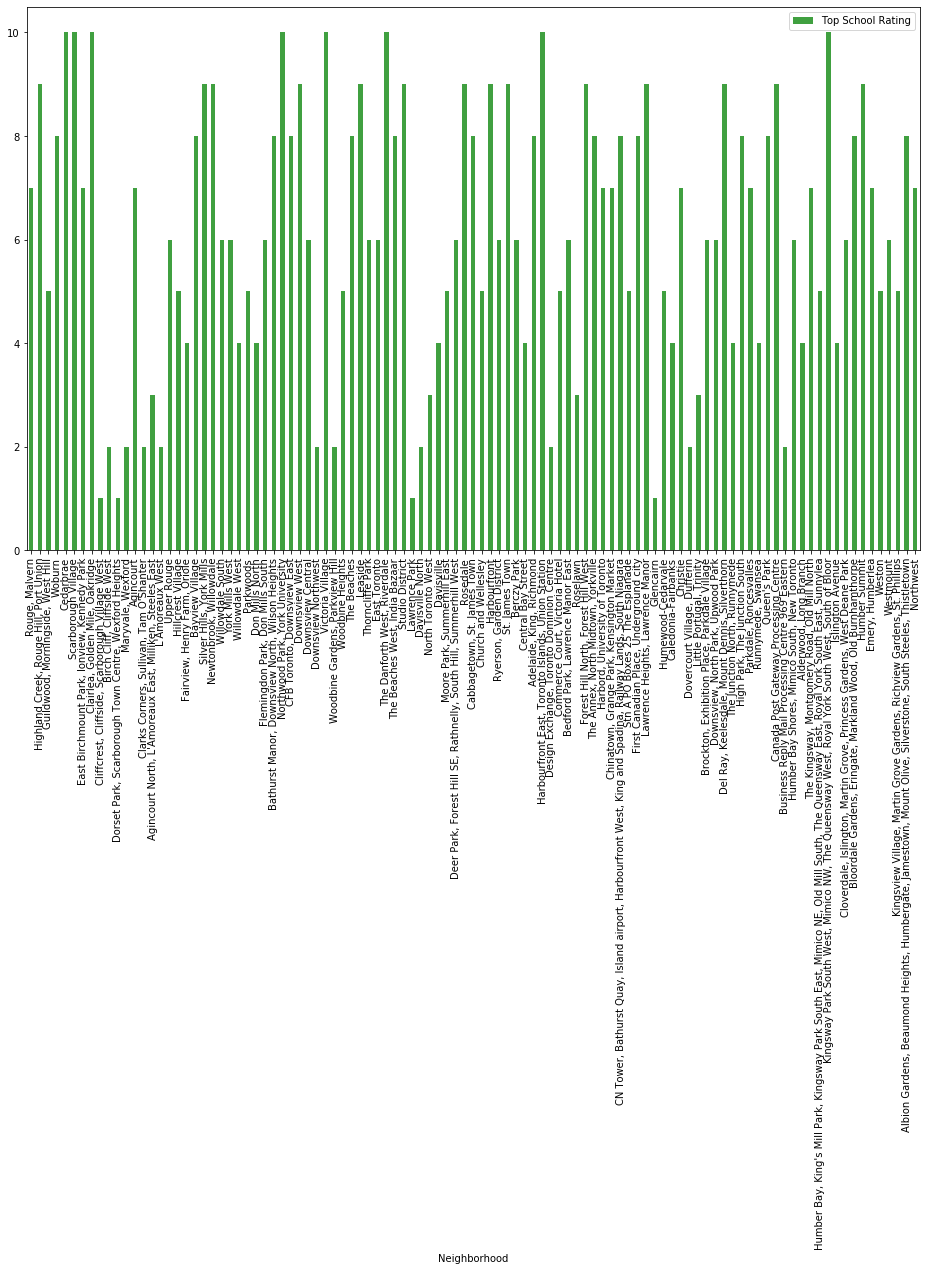

In [56]:
Scarborough_school_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75);

Conclusion: In this project, using k-means cluster algorithm I separated the neighborhood into 10(Ten) different clusters and for 103 different lattitude and logitude from dataset, which have very-similar neighborhoods around them. Using the charts above results presented to a particular neighborhood based on average house prices and school rating have been made.